<a href="https://colab.research.google.com/github/dlphan/CS114.K21/blob/master/sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing


## **Mount drive & install lib**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s /content/drive/'My Drive'/'Machine Learning'/sentiment-classification

In [ ]:
!pip install underthesea
!pip install unidecode
!pip install scikit-learn==0.23.1
!pip install keras==2.2.5
!pip install TensorFlow==1.14

## **Import library**

In [ ]:
import pandas as pd
import glob
import seaborn as sns
import string
from string import digits, punctuation
import re
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.backend import clear_session
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from underthesea import word_tokenize
import unidecode
import joblib
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

## **Import data using Pandas**

**Remove noise on negaitive reviews**

In [6]:
df_neg= pd.read_csv('/content/sentiment-classification/data/negativeReviews1.csv',sep=',',encoding='utf-8',error_bad_lines=False,index_col=None)
df_neg = df_neg.drop(df_neg[(df_neg.STAR != '1') & (df_neg.STAR != '2') & (df_neg.STAR != '3')].index)
df_neg['LABEL']=0
df_neg.head(5)

b'Skipping line 158: expected 2 fields, saw 4\nSkipping line 181: expected 2 fields, saw 17\nSkipping line 601: expected 2 fields, saw 3\nSkipping line 975: expected 2 fields, saw 3\nSkipping line 1324: expected 2 fields, saw 4\nSkipping line 1326: expected 2 fields, saw 5\nSkipping line 1865: expected 2 fields, saw 3\nSkipping line 1929: expected 2 fields, saw 13\nSkipping line 1989: expected 2 fields, saw 3\nSkipping line 2538: expected 2 fields, saw 3\nSkipping line 2710: expected 2 fields, saw 8\nSkipping line 2903: expected 2 fields, saw 3\nSkipping line 2998: expected 2 fields, saw 3\nSkipping line 3348: expected 2 fields, saw 4\nSkipping line 3621: expected 2 fields, saw 5\nSkipping line 3781: expected 2 fields, saw 9\nSkipping line 3982: expected 2 fields, saw 4\nSkipping line 4917: expected 2 fields, saw 5\nSkipping line 4918: expected 2 fields, saw 6\nSkipping line 4924: expected 2 fields, saw 24\nSkipping line 4959: expected 2 fields, saw 7\n'


,CONTENT,STAR,LABEL
0,Vừa dùng được 3 ngày. Nói chung là khá thất vọ...,3,0
1,Nói tóm lại là xiaomi dạo này dùng chán camera...,1,0
2,Giá con này hơi cao nếu giá này nên chọn s10 l...,1,0
3,"toàn chip đời thấp, chip 865 k thấy bán, giá v...",2,0
4,"Máy dùng ok, mình dùng được có 13 ngày máy lỗi...",3,0


**Remove noise on positive reviews**

In [7]:
df_neg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5071 entries, 0 to 5083
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CONTENT  5071 non-null   object
 1   STAR     5071 non-null   object
 2   LABEL    5071 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 158.5+ KB


In [8]:
df_pos= pd.read_csv('/content/sentiment-classification/data/positiveReviews1.csv',sep=',',encoding='utf-8',error_bad_lines=False,index_col=None)
df_pos = df_pos.drop(df_pos[(df_pos.STAR != '4') & (df_pos.STAR != '5')].index)
df_pos['LABEL']=1
df_pos.head(5)

b'Skipping line 700: expected 2 fields, saw 3\nSkipping line 1208: expected 2 fields, saw 3\nSkipping line 1478: expected 2 fields, saw 19\nSkipping line 1480: expected 2 fields, saw 9\nSkipping line 1593: expected 2 fields, saw 5\nSkipping line 1692: expected 2 fields, saw 3\nSkipping line 1964: expected 2 fields, saw 4\nSkipping line 2494: expected 2 fields, saw 3\nSkipping line 2658: expected 2 fields, saw 6\nSkipping line 2659: expected 2 fields, saw 4\nSkipping line 2660: expected 2 fields, saw 13\nSkipping line 3229: expected 2 fields, saw 3\nSkipping line 3423: expected 2 fields, saw 3\nSkipping line 3643: expected 2 fields, saw 5\nSkipping line 4212: expected 2 fields, saw 3\nSkipping line 4501: expected 2 fields, saw 8\nSkipping line 4502: expected 2 fields, saw 4\nSkipping line 5786: expected 2 fields, saw 4\nSkipping line 6156: expected 2 fields, saw 10\nSkipping line 6887: expected 2 fields, saw 4\nSkipping line 6895: expected 2 fields, saw 5\nSkipping line 7623: expected 2

,CONTENT,STAR,LABEL
0,"99% ok. chỉ có Wifi là nó bắt hơi yếu, lướt we...",4,1
1,"camera quá tuyệt vời k có chỗ nào chê, còn dùn...",5,1
2,Nhận hàng xài rất ok. Cầm máy rất đầm tay. Chụ...,5,1
3,Chị bán hàng nhiệt tình xinh gái. khi chuyển c...,5,1
4,Đã nhận máy.cảm nhận rất tốt mà phân vân tí là...,4,1


In [9]:
df_pos=df_pos.loc[0:5500,:]
#df_pos.groupby('STAR').count()
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5474 entries, 0 to 5500
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   CONTENT  5474 non-null   object
 1   STAR     5474 non-null   object
 2   LABEL    5474 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 171.1+ KB


**combine positive reviews & negative reviews then shuffle**

In [10]:
df = pd.concat([df_pos,df_neg], axis=0, ignore_index=True)
df = df.sample(frac=1, axis=1).sample(frac=1).reset_index(drop=True)

df.head(10)

,LABEL,STAR,CONTENT
0,0,3,Mình sài gần 6 tháng pin cầm không nóng ... \n...
1,1,5,Máy ngón trong tầm giá. Phù hợp cho học sinh. ...
2,1,5,Máy sài ngon màn hình đẹp nhưng rất nhanh hết ...
3,0,1,3g với wifi yếu thì khổi bàng..mọi thứ còn lại...
4,0,1,Sau khi sử dụng sản phẩm tôi thấy không hài lò...
5,0,2,"Sp quá tệ: wifi tự bật, vân tay rất chậm, lúc ..."
6,1,4,Sau 2 tháng sử dụng thấy rất là oke mọi thứ đề...
7,0,3,Samsung a50 của mình:\n-Lỗi nắp lưng sau không...
8,1,5,Quá ok trọng tầm giá camera đẹp.máy cầm chắc t...
9,0,2,K lẽ chịu mất 20% để trả lại. Sóng yếu ( cũng ...


## **Data visualization**

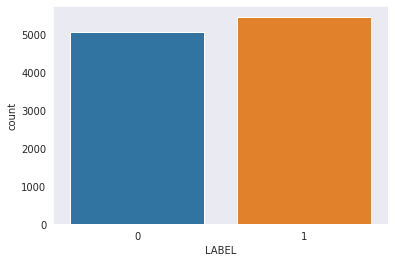

In [11]:
sns.set_style("dark")
sns.countplot(df.LABEL)

**See reivews**

In [12]:
for i,content in enumerate (df['CONTENT'], 1):
    if i > 20:
        break
    else:
        print('\n',i, content)


 1 Mình sài gần 6 tháng pin cầm không nóng ... 
Vừa cập nhật phiên bản android 10 ... Máy nóng lạ thường ... Pin thì chưa được 50% lúc chưa cập nhật .....
Mình không rành lắm ai chỉ mình với 
Lúc chưa cập nhật thì pin vẫn sài rất ok ....
Chỉ sao 1 đêm mà mình cứ tưởng ai đổi máy của mình vậy

 2 Máy ngón trong tầm giá. Phù hợp cho học sinh. 
Nhân viên bán hàng tư vấn ok. Pin trâu


 3 Máy sài ngon màn hình đẹp nhưng rất nhanh hết pin camara sau chụp hình đẹp i phone 6 sài ko ngon bằng i phone 7

 4 3g với wifi yếu thì khổi bàng..mọi thứ còn lại rất ok..máy chưa sài dc 2 tháng các bác ạ

 5 Sau khi sử dụng sản phẩm tôi thấy không hài lòng về chất lượng sản phẩm. Mới sử dụng sản phẩm thường xuyên bị treo (đơ máy)

 6 Sp quá tệ: wifi tự bật, vân tay rất chậm, lúc được lúc không, sp chạy chíp rất chậm, hay bị out ứng dụng

 7 Sau 2 tháng sử dụng thấy rất là oke mọi thứ đều tốt  chơi pubg và liẻn quân thông thi đc khoảng 7tierngs nhung có 1 điểm ko thich cho lăm vân tay trong màn hinh ko đ

## **Data cleansing**

In [13]:
def normalize_text(text):
    #Remove extended characters: ex: đẹppppppp
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

    # lower text
    text = text.lower()

    #Standardize Vietnamese, handle emoj, standardize English
    replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        #Quy các icon về 2 loại emoj: Tích cực hoặc tiêu cực
        "👹": "nagative", "👻": "positive", "💃": "positive",'🤙': ' positive ', '👍': ' positive ',
        "💄": "positive", "💎": "positive", "💩": "positive","😕": "nagative", "😱": "nagative", "😸": "positive",
        "😾": "nagative", "🚫": "nagative",  "🤬": "nagative","🧚": "positive", "🧡": "positive",'🐶':' positive ',
        '👎': ' nagative ', '😣': ' nagative ','✨': ' positive ', '❣': ' positive ','☀': ' positive ',
        '♥': ' positive ', '🤩': ' positive ', 'like': ' positive ', '💌': ' positive ',
        '🤣': ' positive ', '🖤': ' positive ', '🤤': ' positive ', ':(': ' nagative ', '😢': ' nagative ',
        '❤': ' positive ', '😍': ' positive ', '😘': ' positive ', '😪': ' nagative ', '😊': ' positive ',
        '?': ' ? ', '😁': ' positive ', '💖': ' positive ', '😟': ' nagative ', '😭': ' nagative ',
        '💯': ' positive ', '💗': ' positive ', '♡': ' positive ', '💜': ' positive ', '🤗': ' positive ',
        '^^': ' positive ', '😨': ' nagative ', '☺': ' positive ', '💋': ' positive ', '👌': ' positive ',
        '😖': ' nagative ', '😀': ' positive ', ':((': ' nagative ', '😡': ' nagative ', '😠': ' nagative ',
        '😒': ' nagative ', '🙂': ' positive ', '😏': ' nagative ', '😝': ' positive ', '😄': ' positive ',
        '😙': ' positive ', '😤': ' nagative ', '😎': ' positive ', '😆': ' positive ', '💚': ' positive ',
        '✌': ' positive ', '💕': ' positive ', '😞': ' nagative ', '😓': ' nagative ', '️🆗️': ' positive ',
        '😉': ' positive ', '😂': ' positive ', ':v': '  positive ', '=))': '  positive ', '😋': ' positive ',
        '💓': ' positive ', '😐': ' nagative ', ':3': ' positive ', '😫': ' nagative ', '😥': ' nagative ',
        '😃': ' positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': ' positive ', '🤝': ' positive ', '🎈': ' positive ',
        '😗': ' positive ', '🤔': ' nagative ', '😑': ' nagative ', '🔥': ' nagative ', '🙏': ' nagative ',
        '🆗': ' positive ', '😻': ' positive ', '💙': ' positive ', '💟': ' positive ',
        '😚': ' positive ', '❌': ' nagative ', '👏': ' positive ', ';)': ' positive ', '<3': ' positive ',
        '🌝': ' positive ',  '🌷': ' positive ', '🌸': ' positive ', '🌺': ' positive ',
        '🌼': ' positive ', '🍓': ' positive ', '🐅': ' positive ', '🐾': ' positive ', '👉': ' positive ',
        '💐': ' positive ', '💞': ' positive ', '💥': ' positive ', '💪': ' positive ',
        '💰': ' positive ',  '😇': ' positive ', '😛': ' positive ', '😜': ' positive ',
        '🙃': ' positive ', '🤑': ' positive ', '🤪': ' positive ','☹': ' nagative ',  '💀': ' nagative ',
        '😔': ' nagative ', '😧': ' nagative ', '😩': ' nagative ', '😰': ' nagative ', '😳': ' nagative ',
        '😵': ' nagative ', '😶': ' nagative ', '🙁': ' nagative ',
        #Chuẩn hóa 1 số sentiment words/English words
        ':))': '  positive ', ':)': ' positive ', 'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',
        'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
        ' lol ': ' nagative ',' cc ': ' nagative ','cute': u' dễ thương ','huhu': ' nagative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', ' j ': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u'đt ': u' điện thoại ' ,u' wfi ': u' wifi ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ', u'%': u' phần trăm ', u'lác': u' lag ', u'lắc': u' lag ', u'wep': u' web ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' positive ',
        ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ', u'hqa': u' hôm qua ',
        #less than 3 * converted to 1 *, over 3 * converted to 5 *
        u'mìk': u' mình ', u'ròy': u' rồi ', u'hk': u' không ', 'dt ': u' điện thoại ', 'mún': u' muốn ', 'youtobe': u' youtube ',' s ': u' sao ', ' tuột ': u' tụt ', 'nv': u' nhân viên ',
        '6 sao': ' 5star ','6 star': ' 5star ', '5star': ' 5star ','5 sao': ' 5star ','5sao': ' 5star ',
        'starstarstarstarstar': ' 5star ', '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 1star ','2sao':' 1star ',
        '2 starstar':' 1star ','1star': ' 1star ', '0 sao': ' 1star ', '0star': ' 1star ',}

    for k, v in replace_list.items():
      text = text.replace(k, v)

    #remove punctuation 
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)
    # Replace whitespace between terms with a single space
    re_space=re.compile('\s+')
    text=re.sub(re_space,' ',text)
    text=text.strip()
    return text

In [14]:
def standardize_data(df):
    hl_cleansed=[]
    for row in df:
        row=normalize_text(row)
        hl_cleansed.append(row)
    return hl_cleansed

hl_cleansed=standardize_data(df['CONTENT'])
    
    
# View comparison
index=1
print('Original texts :')
print(df['CONTENT'][index])
print('\nAfter cleansed :')
print(hl_cleansed[index])

Original texts :
Máy ngón trong tầm giá. Phù hợp cho học sinh. 
Nhân viên bán hàng tư vấn ok. Pin trâu


After cleansed :
máy ngón trong tầm giá phù hợp cho học sinh nhân viên bán hàng tư vấn ok pin trâu


**Tokenization, remove accents, remove stopwords**

In [15]:
def vi_tokenizer(row):
    return word_tokenize(row, format="text")

def remove_stopwords(stopwords,hl_split):
  sent = [s for s in hl_split if s not in stopwords ]
  return sent

stopwords=set(open('/content/sentiment-classification/data/stopwords.txt').read().split(' ')[:-1])

#for training set
hl_tokens = []
for hl in hl_cleansed:
    hl=vi_tokenizer(hl)
    clean=remove_stopwords(stopwords,hl.split())
    #clean=[remove_accents(s) for s in clean]
    hl_tokens.append(clean)




# View Comparison
index=1
print('Before tokenization :')
print(hl_cleansed[index])
print('\nAfter tokenization :')
print(hl_tokens[index])

Before tokenization :
máy ngón trong tầm giá phù hợp cho học sinh nhân viên bán hàng tư vấn ok pin trâu

After tokenization :
['máy', 'ngón', 'trong', 'tầm', 'giá', 'phù_hợp', 'học_sinh', 'nhân_viên', 'bán', 'hàng', 'tư_vấn', 'ok', 'pin', 'trâu']


Number of words: 10274
Most common words: [('không', 9763), ('máy', 8410), ('pin', 6412), ('mua', 6104), ('mình', 4216), ('chơi', 3438), ('game', 3433), ('mới', 3258), ('dùng', 3185), ('quá', 3008), ('1', 2925), ('tốt', 2915), ('xài', 2910), ('ok', 2894), ('nhanh', 2550)]


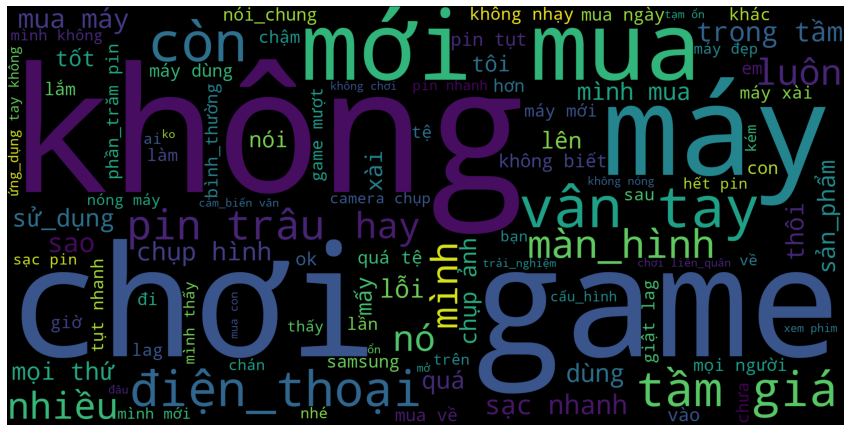

In [16]:
# create bag-of-words
all_words = []

for token in hl_tokens:
    for w in token:
          all_words.append(w)

corpus=' '.join(all_words)
all_words = nltk.FreqDist(all_words)

# print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))


import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
#cloud = np.array(all_words).flatten()
plt.figure(figsize=(15,10))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)
plt.axis("off")
plt.imshow(word_cloud)

## **Data Vectorization**

In [17]:
max_features = 3000
max_token = len(max(hl_tokens,key=len))
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(hl_tokens)
sequences = tokenizer.texts_to_sequences(hl_tokens)
X = pad_sequences(sequences, maxlen=max_token)

# View comparison
index=1
print('Original texts :')
print(df['CONTENT'][index])
print('\nAfter vectorization :')
print(X[index])

Original texts :
Máy ngón trong tầm giá. Phù hợp cho học sinh. 
Nhân viên bán hàng tư vấn ok. Pin trâu


After vectorization :
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 

# Training with RNN

## Building the Model

In [18]:
Y=df['LABEL'].values
Y = np.vstack(Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3, random_state = 42)

In [20]:
clear_session()

In [22]:
embed_dim = 64
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = max_token))
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model.add(Dense(150))
#model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer=Adam(1e-4),metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 455, 64)           192000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 96)                61824     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               14550     
_________________________________________________________________
batch_normalization_2 (Batch (None, 150)               600       
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                

## Training process

In [23]:
#simple early stopping
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

In [24]:
epoch = 20
batch_size = 16
history=model.fit(X_train, Y_train, epochs = epoch, batch_size=batch_size, verbose = 2, validation_split=0.1, callbacks=[es])

Train on 6642 samples, validate on 739 samples
Epoch 1/20
 - 196s - loss: 0.6291 - acc: 0.6432 - val_loss: 0.5069 - val_acc: 0.7686
Epoch 2/20
 - 195s - loss: 0.4983 - acc: 0.7611 - val_loss: 0.4490 - val_acc: 0.8038
Epoch 3/20
 - 199s - loss: 0.4324 - acc: 0.8050 - val_loss: 0.3911 - val_acc: 0.8336
Epoch 4/20
 - 197s - loss: 0.3951 - acc: 0.8279 - val_loss: 0.3702 - val_acc: 0.8552
Epoch 5/20
 - 194s - loss: 0.3718 - acc: 0.8392 - val_loss: 0.3606 - val_acc: 0.8457
Epoch 6/20
 - 201s - loss: 0.3468 - acc: 0.8509 - val_loss: 0.3617 - val_acc: 0.8498


# **Model Evaluation**

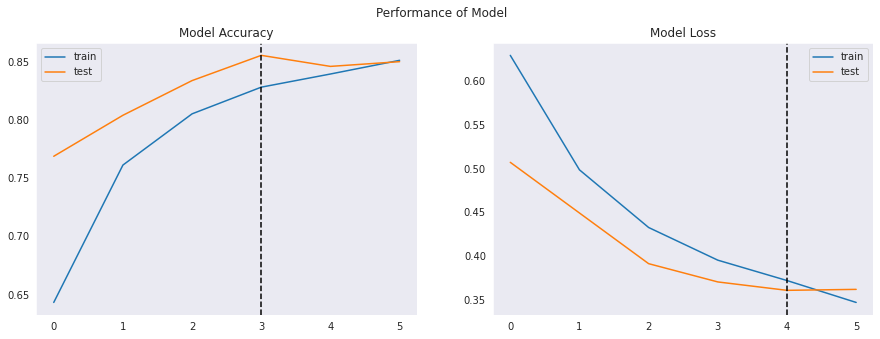

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model")
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
vline_cut = np.where(history.history['val_acc'] == np.max(history.history['val_acc']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

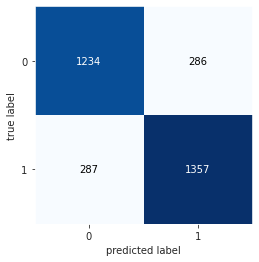

In [26]:
pred=np.around(model.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Y_test,pred))
plt.show()

In [27]:
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1520
           1       0.83      0.83      0.83      1644

    accuracy                           0.82      3164
   macro avg       0.82      0.82      0.82      3164
weighted avg       0.82      0.82      0.82      3164



# **Use Another ML Algorithms to Training**

**Convert Data**

In [28]:
X = [" ".join(x) for x in hl_tokens]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X,df['LABEL'],test_size=0.3)

** Word Vectorization using TF-IDF **

In [29]:
Tfidf_vect = TfidfVectorizer(max_features=3000)
Tfidf_vect.fit(Train_X)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [30]:
print(Tfidf_vect.vocabulary_)

{'lấy': 1385, 'máy': 1500, 'hôm': 1054, '10': 8, 'dùng': 784, 'bây_giờ': 352, 'tất_cả': 2495, 'mọi': 1567, 'thứ': 2266, 'tiệt': 2305, 'vời': 2664, 'giá': 888, 'ăn_đứt': 2798, 'hãng': 1039, '5star': 171, 'nhân_viên': 1696, 'thị_trấn': 2254, 'nhiệt_tình': 1681, 'mới': 1578, 'mua': 1482, 'tháng': 2191, 'sóng': 2071, 'yếu': 2761, 'kết_nối': 1267, 'dữ_liệu': 817, 'di_động': 742, 'hay': 971, 'kém': 1248, 'không': 1201, 'hài_lòng': 1029, 'về': 2653, 'sản_phẩm': 2085, 'ram': 1952, '4g': 141, 'sao': 2018, 'choi': 479, 'liên_quan': 1303, 'lag': 1281, 'quá': 1930, 'zay': 2763, 'chơi': 536, 'luôn': 1338, 'đấy': 2889, 'wi': 2682, 'fi': 841, 'bắt': 400, 'ổn': 2992, 'wifi': 2684, 'thỉnh_thoảng': 2251, 'mất': 1542, 'phản_hồi': 1881, 'chậm': 551, 'còn': 642, 'mượt': 1534, 'mình': 1517, 'game': 861, 'thua': 2178, 'redmi': 1958, 'cách': 628, 'năm': 1781, 'cảm_ứng': 682, 'nhạy': 1713, 'phải_chăng': 1879, 'trải_nghiệm': 2378, 'định': 2918, 'chờ': 578, 'khuyến_mãi': 1177, 'thế_nào': 2248, 'a5': 248, '2017':

## **Trainning on the SVM classifier**

In [31]:
SVM = svm.SVC(C=1.0, kernel='linear', verbose=True)
SVM.fit(Train_X_Tfidf,Train_Y)

[LibSVM]

SVC(kernel='linear', verbose=True)

**Predict and evaluate the SVM classifier**

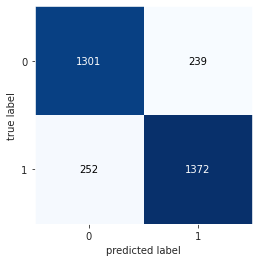

In [32]:
predictions_SVM=SVM.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_SVM))
plt.show()

In [33]:
print(classification_report(Test_Y,predictions_SVM))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1540
           1       0.85      0.84      0.85      1624

    accuracy                           0.84      3164
   macro avg       0.84      0.84      0.84      3164
weighted avg       0.84      0.84      0.84      3164



## **Trainning on the Naive Bayes Classifier**

In [34]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

MultinomialNB()

**Predict and evaluate the Naive Bayes Classifier**

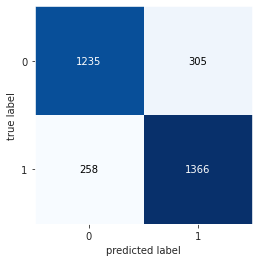

In [35]:
predictions_NB=Naive.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_NB))
plt.show()

In [36]:
print(classification_report(Test_Y,predictions_NB))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1540
           1       0.82      0.84      0.83      1624

    accuracy                           0.82      3164
   macro avg       0.82      0.82      0.82      3164
weighted avg       0.82      0.82      0.82      3164



# **Save model**

In [38]:
joblib.dump(Tfidf_vect, '/content/sentiment-classification/model/tfidf.pkl')
joblib.dump(tokenizer, '/content/sentiment-classification/model/tokenizer_LSTM.pkl')
joblib.dump(model, '/content/sentiment-classification/model/LSTM_model.pkl')
joblib.dump(SVM, '/content/sentiment-classification/model/SVM_model.pkl')
joblib.dump(Naive, '/content/sentiment-classification/model/NB_model.pkl')
joblib.dump(Tfidf_vect.vocabulary_, '/content/sentiment-classification/model/vocabulary.pkl')
joblib.dump(max_token, '/content/sentiment-classification/model/max_token.pkl')

['/content/sentiment-classification/model/max_token.pkl']

# **Enter comment and test**

## **Utils**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s /content/drive/'My Drive'/'Machine Learning'/sentiment-classification

In [ ]:
!pip install underthesea
!pip install unidecode
!pip install scikit-learn==0.23.1
!pip install keras==2.2.5
!pip install TensorFlow==1.14

In [ ]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from underthesea import word_tokenize
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import unidecode
import re
import joblib


path='/content/Sentiment_Classification/'
stopwords=set(open(path+'data/stopwords.txt').read().split(' ')[:-1])

max_token=joblib.load(path+'model/max_token.pkl')
RNN_model=joblib.load(path+'model/LSTM_model.pkl')
RNN_embedding=joblib.load(path+'model/tokenizer_LSTM.pkl')
SVM_model=joblib.load(path+'model/SVM_model.pkl')
NB_model=joblib.load(path+'model/NB_model.pkl')
TFIDF_embedding=joblib.load(path+'model/tfidf.pkl')

In [ ]:
def vi_tokenizer(row):
    return word_tokenize(row, format="text")

def remove_stopwords(stopwords,hl_split):
  sent = [s for s in hl_split if s not in stopwords ]
  return sent

def normalize_text(text):
    #Remove extended characters: ex: đẹppppppp
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

    # lower text
    text = text.lower()

    #Standardize Vietnamese, handle emoj, standardize English
    replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        #Quy các icon về 2 loại emoj: Tích cực hoặc tiêu cực
        "👹": "nagative", "👻": "positive", "💃": "positive",'🤙': ' positive ', '👍': ' positive ',
        "💄": "positive", "💎": "positive", "💩": "positive","😕": "nagative", "😱": "nagative", "😸": "positive",
        "😾": "nagative", "🚫": "nagative",  "🤬": "nagative","🧚": "positive", "🧡": "positive",'🐶':' positive ',
        '👎': ' nagative ', '😣': ' nagative ','✨': ' positive ', '❣': ' positive ','☀': ' positive ',
        '♥': ' positive ', '🤩': ' positive ', 'like': ' positive ', '💌': ' positive ',
        '🤣': ' positive ', '🖤': ' positive ', '🤤': ' positive ', ':(': ' nagative ', '😢': ' nagative ',
        '❤': ' positive ', '😍': ' positive ', '😘': ' positive ', '😪': ' nagative ', '😊': ' positive ',
        '?': ' ? ', '😁': ' positive ', '💖': ' positive ', '😟': ' nagative ', '😭': ' nagative ',
        '💯': ' positive ', '💗': ' positive ', '♡': ' positive ', '💜': ' positive ', '🤗': ' positive ',
        '^^': ' positive ', '😨': ' nagative ', '☺': ' positive ', '💋': ' positive ', '👌': ' positive ',
        '😖': ' nagative ', '😀': ' positive ', ':((': ' nagative ', '😡': ' nagative ', '😠': ' nagative ',
        '😒': ' nagative ', '🙂': ' positive ', '😏': ' nagative ', '😝': ' positive ', '😄': ' positive ',
        '😙': ' positive ', '😤': ' nagative ', '😎': ' positive ', '😆': ' positive ', '💚': ' positive ',
        '✌': ' positive ', '💕': ' positive ', '😞': ' nagative ', '😓': ' nagative ', '️🆗️': ' positive ',
        '😉': ' positive ', '😂': ' positive ', ':v': '  positive ', '=))': '  positive ', '😋': ' positive ',
        '💓': ' positive ', '😐': ' nagative ', ':3': ' positive ', '😫': ' nagative ', '😥': ' nagative ',
        '😃': ' positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': ' positive ', '🤝': ' positive ', '🎈': ' positive ',
        '😗': ' positive ', '🤔': ' nagative ', '😑': ' nagative ', '🔥': ' nagative ', '🙏': ' nagative ',
        '🆗': ' positive ', '😻': ' positive ', '💙': ' positive ', '💟': ' positive ',
        '😚': ' positive ', '❌': ' nagative ', '👏': ' positive ', ';)': ' positive ', '<3': ' positive ',
        '🌝': ' positive ',  '🌷': ' positive ', '🌸': ' positive ', '🌺': ' positive ',
        '🌼': ' positive ', '🍓': ' positive ', '🐅': ' positive ', '🐾': ' positive ', '👉': ' positive ',
        '💐': ' positive ', '💞': ' positive ', '💥': ' positive ', '💪': ' positive ',
        '💰': ' positive ',  '😇': ' positive ', '😛': ' positive ', '😜': ' positive ',
        '🙃': ' positive ', '🤑': ' positive ', '🤪': ' positive ','☹': ' nagative ',  '💀': ' nagative ',
        '😔': ' nagative ', '😧': ' nagative ', '😩': ' nagative ', '😰': ' nagative ', '😳': ' nagative ',
        '😵': ' nagative ', '😶': ' nagative ', '🙁': ' nagative ',
        #Chuẩn hóa 1 số sentiment words/English words
        ':))': '  positive ', ':)': ' positive ', 'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',
        'kg ': u' không ',' not ': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
        ' lol ': ' nagative ',' cc ': ' nagative ','cute': u' dễ thương ','huhu': ' nagative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', ' j ': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u'đt ': u' điện thoại ' ,u' wfi ': u' wifi ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ', u'%': u' phần trăm ', u'lác': u' lag ', u'lắc': u' lag ', u'wep': u' web ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' positive ',
        ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ', u'hqa': u' hôm qua ',
        #less than 3 * converted to 1 *, over 3 * converted to 5 *
        u'mìk': u' mình ', u'ròy': u' rồi ', u'hk': u' không ', 'dt ': u' điện thoại ', 'mún': u' muốn ', 'youtobe': u' youtube ',' s ': u' sao ', ' tuột ': u' tụt ', 'nv': u' nhân viên ',
        '6 sao': ' 5star ','6 star': ' 5star ', '5star': ' 5star ','5 sao': ' 5star ','5sao': ' 5star ',
        'starstarstarstarstar': ' 5star ', '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 1star ','2sao':' 1star ',
        '2 starstar':' 1star ','1star': ' 1star ', '0 sao': ' 1star ', '0star': ' 1star ',}

    for k, v in replace_list.items():
      text = text.replace(k, v)
    #remove punctuation 
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)
    # Replace whitespace between terms with a single space
    re_space=re.compile('\s+')
    text=re.sub(re_space,' ',text)
    text=text.strip()
    return text

def standardize_data(df):
    hl_cleansed=[]
    for row in df:
        row=normalize_text(row)
        row=vi_tokenizer(row)
        row=remove_stopwords(stopwords,row.split())
        hl_cleansed.append(row)
    return hl_cleansed

def input_vectorization(input_token,choice):
  if choice=='RNN':
    sequences = RNN_embedding.texts_to_sequences(input_token)
    X = pad_sequences(sequences, maxlen=max_token)
  else:
    list_token=[' '.join(token) for token in input_token ]
    X = TFIDF_embedding.transform(list_token)
  return X
       

def predict(text,choice):
  token=standardize_data([text])
  if choice=='RNN':
    X=input_vectorization(token,'RNN')
    if np.around(RNN_model.predict(X))==1:
      print(text)
      print("=============> Positive\n")
    else:
      print(text)
      print("=============> Negative\n")
  elif choice=='SVM':
    X=input_vectorization(token,'SVM')
    if SVM_model.predict(X)[0]==1:
      print(text)
      print("=============> Positive\n")
    else:
      print(text)
      print("=============> Negative\n")
  else:
    X=input_vectorization(token,'NB')
    if NB_model.predict(X)[0]==1:
      print(text)
      print("=============> Positive\n")
    else:
      print(text)
      print("=============> Negative\n")




def multi_predict(list_data,choice):
  result=dict()
  list_token=standardize_data(list_data)
  rs=[]
  num_positive=None
  num_negative=None
  X=input_vectorization(list_token,choice)
  if choice=='RNN':
    rs=np.around(RNN_model.predict(X))
  elif choice=='SVM':
    rs = SVM_model.predict(X)
  elif choice=='NB':
    rs = NB_model.predict(X)
    
  num_positive=np.count_nonzero(rs == 1)
  num_negative=np.count_nonzero(rs == 0)
  rs=rs.flatten().astype(int)
  
  percentage_of_positive= round(num_positive/(num_positive + num_negative)*100,2)
  index_of_positive=[i for i, e in enumerate(rs) if e == 1]
  index_of_negative=[i for i, e in enumerate(rs) if e == 0]
  recommend='Máy được khen trên '+str(percentage_of_positive)+'%, mua đi !!' if percentage_of_positive > 60 \
                            else 'Máy bị chê quá nhiều ('+str(100-percentage_of_positive)+'%), không nên mua'

  result['Number of positive']=num_positive
  result['Number of negative']=num_negative
  result['Recommend']=recommend
  result['Index of positive']= index_of_positive
  result['Index of negative']= index_of_negative
  result['Model']= choice


  return result

## **Predict**

In [ ]:
cmt0='máy bắt wifi như lolllllllllllll'

cmt1='Quá buồn khi mua em này, loa cuộc gọi siêu bé, không nghe được, vân tay không nhạy 1 tí gì. Mình mua được 2 tuần. Giờ mình phải làm sao????'

cmt2='ngon quá, sẽ ủng hộ shop dài dài.'

cmt3='Quá tuyệt, siêu phẩm 2020 là đây, giá rẻ mà cấu hình lại cao nữa.'

cmt4='Rất buồn,máy ok đó nhưng TGDĐ làm ăn bảo hành như cc, mang ra đổi trả không chịu !!!'

cmt5='Đã thử sang note 10 nhưng vẫn quay lại với IPhone. Thề androi như bùi mng ạ.. phần gia công iphone làm rất tốt. Cái note 10+ thật sự đc mỗi cái màn hình ngon'

cmt6='Máy thì ngon nhưng chủ yếu dùng nghe gọi nên giá hơi chát. Tuy nhiên iphone dùng 4,5 năm vẫn tốt. Nên mua.'

cmt7="Mình mua được hơn 1 tháng rồi máy hoạt động êm nước lọc ngon nhưng không được hài lòng cho lắm"

cmt=[cmt0,cmt1,cmt2,cmt3,cmt4,cmt5,cmt6,cmt7]

**Multi predict**

In [ ]:
multi_predict(cmt,'RNN')

***Using RNN model to predict***

In [ ]:
predict(cmt2,'RNN')

***Using SVM clasifier***

In [ ]:
predict(cmt2,'SVM')

***Using NB clasifier***

In [ ]:
predict(cmt2,'NB')